In [7]:
#Section 1
#Load data and ensure their lat and lon indexes align

import pandas as pd

# Load the main datasets
csv_file1 = "/Users/nattamonmaneenoi/Downloads/C204_FinalProject/0.1SUOMIBurnArea_grid_density.csv"  # Burn Area
csv_file2 = "/Users/nattamonmaneenoi/Downloads/burn_area/0.1burn_area_density_final.csv"  # Final Burn Area
csv_file3 = "/Users/nattamonmaneenoi/Downloads/C204_FinalProject/dominant_crop_type_2D.csv"  # Crop Types
csv_file4 = "/Users/nattamonmaneenoi/Downloads/C204_FinalProject/0.1SUOMI_AverageFRP.csv"  # FRP Data

# Load all datasets
df1 = pd.read_csv(csv_file1, index_col=0)  # SuomiBurnArea
df2 = pd.read_csv(csv_file2, index_col=0)  # BurnArea
df3 = pd.read_csv(csv_file3, index_col=0)  # Crop Types
df4 = pd.read_csv(csv_file4, index_col=0)  # FRP Data

# Rename index and columns for consistency
for df in [df1, df2, df3, df4]:
    df.index.name = 'Latitude'
    df.columns.name = 'Longitude'

# Convert DataFrames to long format for easier merging
df1_long = df1.reset_index().melt(id_vars=['Latitude'], var_name='Longitude', value_name='Density1')
df2_long = df2.reset_index().melt(id_vars=['Latitude'], var_name='Longitude', value_name='Density2')
df3_long = df3.reset_index().melt(id_vars=['Latitude'], var_name='Longitude', value_name='CropType')
df4_long = df4.reset_index().melt(id_vars=['Latitude'], var_name='Longitude', value_name='FRP')

# Ensure Longitude and Latitude are numeric for all DataFrames
for df in [df1_long, df2_long, df3_long, df4_long]:
    df['Longitude'] = pd.to_numeric(df['Longitude']).round(2)
    df['Latitude'] = pd.to_numeric(df['Latitude']).round(2)

# Merge all DataFrames on Latitude and Longitude
merged = pd.merge(df1_long, df2_long, on=['Latitude', 'Longitude'], how='inner')
merged = pd.merge(merged, df3_long, on=['Latitude', 'Longitude'], how='inner')
merged = pd.merge(merged, df4_long, on=['Latitude', 'Longitude'], how='inner')

# Remove rows with 0 or NaN values in Density1, Density2, or FRP
filtered = merged[(merged['Density1'] > 0) & (merged['Density2'] > 0) & (merged['FRP'] > 0)].dropna()
crop_types = filtered['CropType'].unique()

RMSE for Ridge Regression: 0.7097249667705814
RMSE for SVR: 0.7161643320549164
RMSE for Decision Tree: 1.0011862086267156


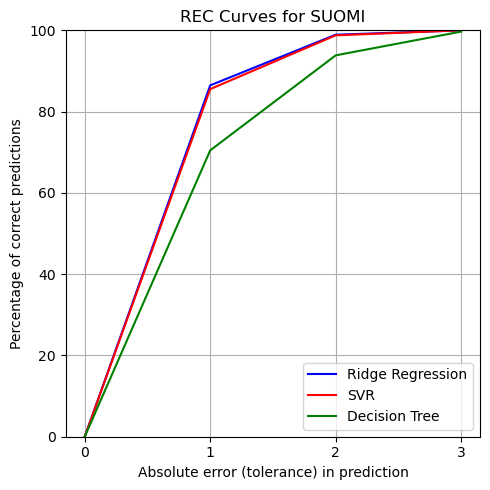

In [8]:
#STEP 2: 
#Log-transform and Normalize using StandardScaler() 
#Then proceed with Ridge Regression, SVR, and Desicion Tree Regression model
#And compute RMSE and plot REC curve for each machine learning model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Log-transform 'Density1' and 'Density2', retain 'FRP' as is
filtered['Density1'] = np.log10(filtered['Density1'] * 1_000_000)
filtered['Density2'] = np.log10(filtered['Density2'] * 1_000_000)
filtered['FRP'] = np.log10(filtered['FRP'] * 1_000_000)

# Normalize predictors (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ensure both Density1 and FRP are included as predictors
X_unscaled = filtered[['Density1', 'FRP']]
y_unscaled = filtered['Density2']

# Scale predictors and target
X_scaled = scaler_X.fit_transform(X_unscaled)
y_scaled = scaler_y.fit_transform(y_unscaled.values.reshape(-1, 1)).flatten()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

# Train Ridge Regression Model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Train SVR Model
svr_model = SVR()
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Train Decision Tree Model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Inverse transform predictions to original scale for interpretability
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_ridge_original = scaler_y.inverse_transform(y_pred_ridge.reshape(-1, 1)).flatten()
y_pred_svr_original = scaler_y.inverse_transform(y_pred_svr.reshape(-1, 1)).flatten()
y_pred_tree_original = scaler_y.inverse_transform(y_pred_tree.reshape(-1, 1)).flatten()

# Calculate RMSE for each model
rmse_ridge = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge_original))
rmse_svr = np.sqrt(mean_squared_error(y_test_original, y_pred_svr_original))
rmse_tree = np.sqrt(mean_squared_error(y_test_original, y_pred_tree_original))

print("RMSE for Ridge Regression:", rmse_ridge)
print("RMSE for SVR:", rmse_svr)
print("RMSE for Decision Tree:", rmse_tree)

# REC Curve Calculation
def rec(predictions, actual, tolerance):
    return np.mean(np.abs(predictions - actual) <= tolerance) * 100

tol_max = 4
rec_ridge = [rec(y_pred_ridge_original, y_test_original, tol) for tol in range(tol_max)]
rec_svr = [rec(y_pred_svr_original, y_test_original, tol) for tol in range(tol_max)]
rec_tree = [rec(y_pred_tree_original, y_test_original, tol) for tol in range(tol_max)]

# Plot REC Curves
plt.figure(figsize=(5, 5))
plt.title("REC Curves for SUOMI")
plt.xlabel("Absolute error (tolerance) in prediction")
plt.ylabel("Percentage of correct predictions")
plt.xticks(range(0, tol_max + 1, 1))
plt.ylim(0, 100)
plt.yticks(range(0, 101, 20))
plt.grid(True)

plt.plot(range(tol_max), rec_ridge, label='Ridge Regression', color='blue')
plt.plot(range(tol_max), rec_svr, label='SVR', color='red')
plt.plot(range(tol_max), rec_tree, label='Decision Tree', color='green')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Model Equation: y = 4.04 + 0.32*AREA + 0.00*FRP
Pearson r-value: 0.51
p-value: 0.000


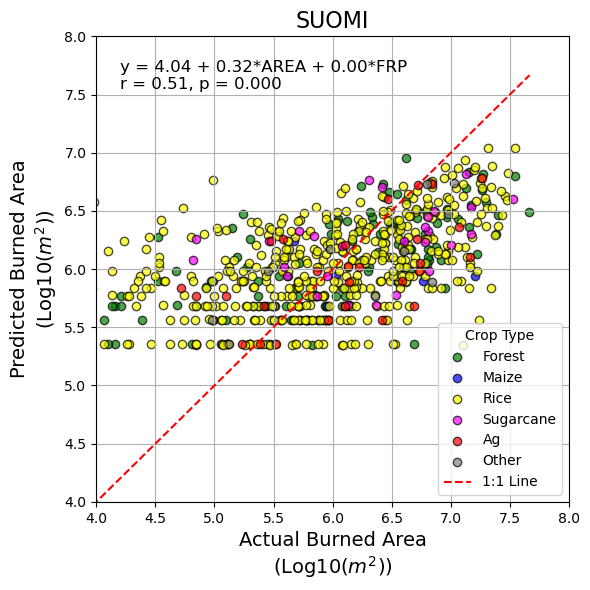

In [9]:
#STEP 3
#plot scatter plot of unscaled predicted burned area based on Ridge Regression vs unscaled reference burned area 
#add a 1:1 line
#color-coded the scatters by their crop types
#show the fitted model equation with R-value as well as p value

from scipy.stats import pearsonr

# Calculate r-value and p-value
r_value, p_value = pearsonr(y_test_original, y_pred_ridge_original)

# Retrieve coefficients from Ridge Regression model
ridge_coefficients = ridge_model.coef_
intercept_ridge = ridge_model.intercept_

# Model equation with original scale terms
coef_density1 = ridge_coefficients[0] / scaler_y.scale_[0] * scaler_X.scale_[0]
coef_frp = ridge_coefficients[1] / scaler_y.scale_[0] * scaler_X.scale_[1]
intercept_original = scaler_y.mean_[0] - (
    coef_density1 * scaler_X.mean_[0] + coef_frp * scaler_X.mean_[1]
)
equation = f"y = {intercept_original:.2f} + {coef_density1:.2f}*AREA + {coef_frp:.2f}*FRP"

# Print model details
print(f"Model Equation: {equation}")
print(f"Pearson r-value: {r_value:.2f}")
print(f"p-value: {p_value:.3f}")

test_indices = X_test.shape[0]
filtered_test_data = filtered.iloc[-test_indices:]  # Select rows corresponding to the test set
test_data = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_ridge_original,
}, index=filtered_test_data.index)
test_data['CropType'] = filtered_test_data['CropType']

# Generate distinct colors for each crop type
crop_types = test_data['CropType'].unique()
colors = plt.cm.tab10(range(len(crop_types)))  # Use a colormap with sufficient colors
color_map = dict(zip(crop_types, colors))

color_map = {
    "Forest": "green",
    "Maize": "blue",
    "Rice": "yellow",
    "Sugarcane": "magenta",
    "Ag":"red",
    "Other": "gray"
}
# Scatter plot for Ridge Regression on original scale
plt.figure(figsize=(6, 6))
for crop, color in color_map.items():
    subset = test_data[test_data['CropType'] == crop]
    plt.scatter(subset['Actual'], subset['Predicted'], color=color, label=crop, alpha=0.7, edgecolor='k')

# Add a 1:1 line for reference
plt.plot(
    [test_data['Actual'].min(), test_data['Actual'].max()],
    [test_data['Actual'].min(), test_data['Actual'].max()],
    color='red', linestyle='--', label='1:1 Line'
)

# Annotate plot with model equation and r-value
plt.text(0.05, 0.95, f"{equation}\nr = {r_value:.2f}, p = {p_value:.3f}",
         fontsize=12, transform=plt.gca().transAxes, verticalalignment='top')

# Customize plot
plt.title('SUOMI', fontsize=16)
plt.xlabel('Actual Burned Area\n(Log10($m^2$))', fontsize=14)
plt.ylabel('Predicted Burned Area\n(Log10($m^2$))', fontsize=14)
plt.ylim(4,8)
plt.xlim(4,8)
plt.legend(title='Crop Type', fontsize=10, loc='lower right')
plt.grid(True)
plt.tight_layout()


# Display the plot
plt.show()

